In [107]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Masking,Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed,MaxPooling1D, Flatten, Conv1D,Conv2D,Dropout, MaxPooling2D, GRU # for creating layers inside the Neural Network
from keras.optimizers import Adam , SGD
from keras import metrics
from keras.utils import plot_model
# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import numpy.ma as ma
# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split
# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version
from matplotlib import pyplot as plt

#file accessing
import os
# time stuff
from datetime import timedelta
import calendar


Tensorflow/Keras: 2.9.0
pandas: 1.4.2
numpy: 1.22.4
sklearn: 1.1.1
plotly: 5.9.0


In [108]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against the training feature and label."""

  # Label the axes.
  plt.xlabel("feature")
  plt.ylabel("label")

  # Plot the feature values vs. label values.
  plt.scatter(feature, label)

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = feature[-1]
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()

def plot_the_loss_curve(epochs, rmse):
  """Plot the loss curve, which shows loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")
  #epochs.remove(max(epochs))
  
  #rmse.drop(max(rmse))
  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([min(rmse)*0.97, max(rmse)])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


##### Read from file and establish dataframe and future functions

In [109]:
df=pd.read_csv('InSAR_data_south/displacement/export_dataframe1.csv')
df=df.set_index([df.columns[0],df.columns[1]])
df.columns=pd.to_datetime(df.columns, format='%Y%m%d')
df=df.dropna(axis=0, how='all')#drop full nan rows

##### Remove next line to include all data

In [110]:
#df=df.iloc[100000:500000] #cuts data to long 120-119 approx
#df=df.iloc[200000:200050]
df=df.iloc[200300:205000]
df

2014-11-08  2014-12-02  2014-12-26  2015-02-12  \
Longitude Latitude                                                   
-120.4087 35.7111          0.0     -9.7682     1.32970      2.5644   
          35.7131          0.0     -9.7499     1.03440      2.3852   
          35.7151          0.0     -9.7651     0.91867      2.1549   
          35.7171          0.0     -9.7098     1.06820      2.2616   
          35.7191          0.0     -9.7055     1.18930      2.2306   
...                        ...         ...         ...         ...   
-120.4027 36.7274          0.0     -7.2276     0.73694      2.6327   
          36.7294          0.0     -7.3210     0.70109      2.4708   
          36.7314          0.0     -7.2388     0.46256      2.4291   
          36.7334          0.0     -7.2526     0.31420      2.0908   
          36.7394          0.0     -7.1203    -0.03439      2.3198   

                    2015-03-08  2015-04-01  2015-04-25  2015-05-19  \
Longitude Latitude                                                   
-120.4087 35.7111     -2.05550    0.206280    -1.92500    0.070012   
          35.7131     -2.17930    0.114360    -1.97630    0.061350   
          35.7151     -2.24280    0.047868    -2.09290   -0.009276   
          35.7171     -2.23340    0.121860    -2.03820    0.117630   
          35.7191     -2.20010    0.197790    -1.92230    0.277210   
...                        ...         ...         ...         ...   
-120.4027 36.7274     -0.37212    4.126900    -0.77547    1.426300   
          36.7294     -0.53777    3.980700    -0.90438    1.269800   
          36.7314     -0.72740    3.727700    -1.12300    0.910640   
          36.7334     -1.04390    3.479200    -1.13890    0.931990   
          36.7394     -0.72105    3.620500    -1.04990    0.924510   

                    2015-06-12  2015-07-06  ...  2018-10-18  2018-10-30  \
Longitude Latitude                          ...                           
-120.4087 35.7111      -1.3901     0.91577  ...     -5.1163    -2.91050   
          35.7131      -1.3482     0.95156  ...     -4.6685    -2.42550   
          35.7151      -1.3706     0.94827  ...     -3.9746    -1.69430   
          35.7171      -1.2118     1.12510  ...     -3.4391    -1.10440   
          35.7191      -1.0178     1.30990  ...     -2.8703    -0.48555   
...                        ...         ...  ...         ...         ...   
-120.4027 36.7274       3.9578    -0.83484  ...     -4.7423    -1.76260   
          36.7294       3.9292    -0.64295  ...     -4.2087    -1.23680   
          36.7314       3.6537    -0.98271  ...     -4.7961    -1.85590   
          36.7334       3.3421    -1.11060  ...     -5.8926    -2.96370   
          36.7394       3.2634    -1.40170  ...     -5.4141    -2.53130   

                    2018-11-11  2018-11-17  2018-11-23  2018-12-05  \
Longitude Latitude                                                   
-120.4087 35.7111      -4.1619     -4.1025     -6.0477     -6.6512   
          35.7131      -3.7174     -3.6452     -5.5758     -6.2420   
          35.7151      -3.0357     -2.9414     -4.9009     -5.6663   
          35.7171      -2.5180     -2.4014     -4.3470     -4.9772   
          35.7191      -1.9774     -1.8200     -3.7522     -4.2980   
...                        ...         ...         ...         ...   
-120.4027 36.7274      -2.7142     -3.0876     -6.2273     -5.2793   
          36.7294      -2.1775     -2.5592     -5.7036     -4.6893   
          36.7314      -2.7951     -3.1822     -6.3403     -5.3780   
          36.7334      -3.8852     -4.2657     -7.4344     -6.3047   
          36.7394      -3.4532     -3.8240     -6.9644     -6.0637   

                    2018-12-17  2018-12-29  2019-01-10  2019-01-22  
Longitude Latitude                                                  
-120.4087 35.7111      -4.1006    -2.63540   -2.323500    -2.11000  
          35.7131      -3.6871    -2.20480   -1.915800    -1.67590  
          35.7151      -3.1530    -

In [111]:
df2=pd.read_csv('InSAR_data_south/displacement/groundwater.csv')
df2=df2.set_index([df2.columns[0],df2.columns[1]])
df2.columns=pd.to_datetime(df2.columns, format='%Y-%m-%d')
df2=df2.dropna(axis=0, how='all')#drop full nan rows
for y in range(df.columns.size):# includes all dates and adds nans
    if df.columns[y] != df2.columns[y]: #if column is misssing insert it
        df2.insert(loc=y,column=df.columns[y],value=np.nan*11286,allow_duplicates=False)
df2.index[0]
type(df2.index[0])


tuple

In [112]:
df2.index.size


11286

In [113]:
for x in range(df2.index.size): #for each row
    curr=np.nan
    for y in range(df2.columns.size): #for each value in the row
        n=0
        while np.isnan(curr): # if saved value is empty
            curr=df2.iloc[x].values[n] #look for next actual value
            n+=1
        if np.isnan(df2.iloc[x].values[y]):#if data is nan then replace with previous curr value
            df2.iat[x,y]=curr
            #df2.iloc[x].values[y]=curr
        else:
            curr= df2.iloc[x].values[y]
                

df2

# Timestep

In [ ]:
timestep=10
# 1 2 3 4 5 6 7 ...
# w/ timestep of 2
# [[1,2][2,3][3,4]

# Shaping function (remove start and step for first for loop to include all data)

In [ ]:
def shaping2(datain,datain2, timestep):
    #print(arr)
    cnt=0
    for row in range(len(datain.index)): #picks a row at every iteration, allows to reduction of input and inclusion of multiple time series, remove start and step to run on full dataset 
    # Convert input dataframe to array and flatten
        #datain.iloc[row].fillna(datain.iloc[row].mean).to_numpy().flatten()

        if datain.index[row] not in datain2.index:
            #print("Not found", cnt)
            continue
        
        print("found", row)
        j=0
        
        arr2=datain2.loc[datain.index[row]].to_numpy().flatten() # flatten row
        while j<3:
            print(arr2)
        scaler = MinMaxScaler()
        arr2 = scaler.fit_transform(arr2.reshape(-1, arr2.shape[-1])).reshape(arr2.shape)
        arr=datain.iloc[row].to_numpy().flatten()
        arr=np.where(np.isnan(arr), ma.array(arr, mask=np.isnan(arr)).mean(), arr) 
        #arr2=np.where(np.isnan(arr2), ma.array(arr2, mask=np.isnan(arr2)).mean(), arr2) 
        arr3=np.concatenate((arr,arr2)).reshape(2,110)
        
        
        for mth in range(0, len(datain2.columns)-(2*timestep)+1): # Define range lenght of the dates - 2* amount of timesep?? +1
            cnt=cnt+1 # Gives us the number of samples. Later used to reshape the data
            X_start=mth # Start month for inputs of each sample
            X_end=mth+timestep # End month for inputs of each sample
            Y_start=mth+timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
            Y_end=mth+2*timestep # End month for targets of each sample.  
            
            # Assemble input and target arrays containing all samples
            if cnt==1:
                X_comb=arr3[:,X_start:X_end]
                Y_comb=arr3[0][Y_start:Y_end]
            else: 
                X_comb=np.append(X_comb, arr3[:,X_start:X_end])
                Y_comb=np.append(Y_comb, arr3[:1,Y_start:Y_end])
    
    # Reshape input and target arrays
    X_out=np.reshape(X_comb, (cnt, timestep, 2))
    Y_out=np.reshape(Y_comb, (cnt, timestep, 1))
    return X_out, Y_out

In [ ]:
# print(df2.index.values[0])
# #arr=df.loc[df.index[0]]
# if df2.index.values in df.index.values:
#     print(True)
train, test = train_test_split(df, test_size=0.2, random_state=64, shuffle=False)
#train2, test2 = train_test_split(df2, test_size=0.2, random_state=64, shuffle=False)
X_train, Y_train=shaping2(datain=train,datain2=df2, timestep= timestep )
X_test, Y_test=shaping2(datain=test,datain2=df2, timestep= timestep )


found 344
found 385
found 548
found 589
found 699
found 739
found 781
found 822
found 1631
found 1807
found 1849
found 1886
found 1916
found 2015
found 2034
found 2069
found 2110
found 3158
found 3197
found 3239
found 3367
found 3400
found 3427
found 3572
found 3613
found 802
found 840
found 927


In [ ]:
X_train.shape

(2275, 10, 2)

In [ ]:
X_train

array([[[ 0.     , -6.9599 ],
        [ 0.8769 ,  1.9144 ],
        [-0.61955,  3.9298 ],
        ...,
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ]],

       [[-6.9599 ,  0.8769 ],
        [ 1.9144 , -0.61955],
        [ 3.9298 ,  1.0864 ],
        ...,
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ]],

       [[ 0.8769 ,  1.9144 ],
        [-0.61955,  3.9298 ],
        [ 1.0864 ,  2.7699 ],
        ...,
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ]],

       ...,

       [[ 2.9122 ,  2.4613 ],
        [ 2.2079 ,  4.0117 ],
        [ 2.1379 , -4.8616 ],
        ...,
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ]],

       [[ 2.4613 ,  2.2079 ],
        [ 4.0117 ,  2.1379 ],
        [-4.8616 ,  2.7732 ],
        ...,
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ],
        [ 0.     ,  0.     ]],

       [[ 2.

In [ ]:
X_train[0]

array([[ 0.     , -6.9599 ],
       [ 0.8769 ,  1.9144 ],
       [-0.61955,  3.9298 ],
       [ 1.0864 ,  2.7699 ],
       [ 3.4    ,  2.466  ],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ]])

In [ ]:
X_train[1]

array([[-6.9599 ,  0.8769 ],
       [ 1.9144 , -0.61955],
       [ 3.9298 ,  1.0864 ],
       [ 2.7699 ,  3.4    ],
       [ 2.466  ,  0.87414],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ]])

In [ ]:
# # data normalization with sklearn
# from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler

# # fit scaler on training data
# #norm = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
# #norm= MaxAbsScaler().fit(X_train)
# # transform training data
# X_train_norm = norm.transform(X_train)

# # transform testing dataabs
# X_test_norm = norm.transform(X_test)
# # transform training data
# Y_train_norm = norm.transform(Y_train)

# # transform testing dataabY
# Y_test_norm = norm.transform(Y_test)

##### Step 2 - Split and Shape data

##### Step 3 - Specify the structure of a Neural Network, first model

In [ ]:
model2 = Sequential(name="biLSTM-Model") # Model
#model2.add(Masking(mask_value=-1000, input_shape=(timestep, 1)))
model2.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model2.add(Bidirectional(LSTM(units=64, activation='relu', recurrent_activation='sigmoid', stateful=False), name='Hidden-LSTM-Encoder-Layer')) # Encoder Layer
model2.add(RepeatVector(Y_train.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model2.add(Bidirectional(LSTM(units=64, activation='relu', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-LSTM-Decoder-Layer')) # Decoder Layer
model2.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x
#optimizer=Adam(.005)
model2.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'accuracy'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
        
             )

In [ ]:
##### Train model

In [ ]:

history = model2.fit(X_train, # input data
                    Y_train, # target data
                    batch_size=2, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=50, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=2, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=100, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                
                   )




Epoch 1/50
910/910 - 9s - loss: 11.4312 - mean_squared_error: 11.4312 - accuracy: 0.0000e+00 - 9s/epoch - 10ms/step
Epoch 2/50
910/910 - 6s - loss: 8.7531 - mean_squared_error: 8.7531 - accuracy: 0.0000e+00 - 6s/epoch - 6ms/step
Epoch 3/50
910/910 - 6s - loss: 7.6955 - mean_squared_error: 7.6955 - accuracy: 0.0000e+00 - 6s/epoch - 6ms/step
Epoch 4/50
910/910 - 6s - loss: 7.3539 - mean_squared_error: 7.3539 - accuracy: 0.0000e+00 - 6s/epoch - 7ms/step
Epoch 5/50
910/910 - 6s - loss: 7.1451 - mean_squared_error: 7.1451 - accuracy: 0.0000e+00 - 6s/epoch - 6ms/step
Epoch 6/50
910/910 - 6s - loss: 6.8264 - mean_squared_error: 6.8264 - accuracy: 0.0000e+00 - 6s/epoch - 6ms/step
Epoch 7/50
910/910 - 6s - loss: 6.4029 - mean_squared_error: 6.4029 - accuracy: 0.0000e+00 - 6s/epoch - 7ms/step
Epoch 8/50
910/910 - 6s - loss: 6.2540 - mean_squared_error: 6.2540 - accuracy: 0.0000e+00 - 6s/epoch - 7ms/step
Epoch 9/50
910/910 - 6s - loss: 6.0307 - mean_squared_error: 6.0307 - accuracy: 0.0000e+00 - 

##### Step 4 - Plot loss over epochs

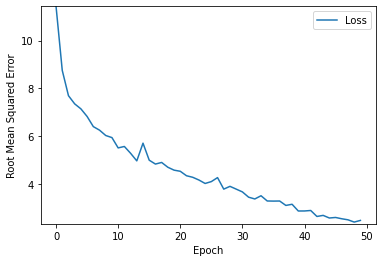

In [ ]:
# Gather the trained model's weight and bias.
trained_weight = model2.get_weights()[0]
trained_bias = model2.get_weights()[1]

  # The list of epochs is stored separately from the 
  # rest of history.
epochs = history.epoch
  
  # Gather the history (a snapshot) of each epoch.
#hist = pd.DataFrame(history.history)

  # Specifically gather the model's root mean 
  # squared error at each epoch. 
rmse = history.history["mean_squared_error"]

#plot_the_model(trained_weight, trained_bias, X_test, Y_train)
plot_the_loss_curve(epochs, rmse)

##### Step 5 - Print Performance Summary

In [ ]:
print("")
print('-------------------- Model Summary --------------------')
model2.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model2.evaluate(X_test, Y_test)
print("")


-------------------- Model Summary --------------------
Model: "biLSTM-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-LSTM-Encoder-Layer (  (None, 128)              34304     
 Bidirectional)                                                  
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 10, 128)          0         
 Vector)                                                         
                                                                 
 Hidden-LSTM-Decoder-Layer (  (None, 10, 128)          98816     
 Bidirectional)                                                  
                                                                 
 Output-Layer (TimeDistribut  (None, 10, 1)            129       
 ed)                                                             
                                                               

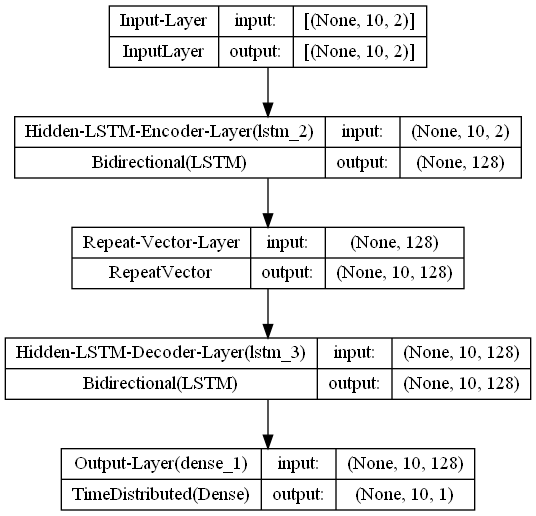

In [ ]:
from keras.utils import plot_model,model_to_dot
plot_model(model2, show_shapes=True, to_file='plotmodelbilstm0810.png')


In [ ]:
model_to_dot(model2,show_shapes=True)


In [ ]:
model2